# Model tuning

## Data preparation

In [1]:
# Ignore all warnings
from warnings import simplefilter
simplefilter(action='ignore')

# Import dependencies
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import pickle

# Import the models from SKLearn (Model 1 through Model 6)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Local module
from ml_classification import model_performance

In [62]:
# Shooter data
shooters_df = pd.read_csv(Path('model_blackbox_shooters.csv'))

# General Population data
genpop_df = pd.read_csv(Path('model_blackbox_genpop.csv'))

# Create one table with all data
all_data = pd.concat([shooters_df, genpop_df], axis=0)

# Separate the data into labels and features
# Separate the y variable, the labels
y = all_data['Classification']

# Separate the X variable, the features
X = all_data.drop(columns='Classification')

# Get dummies
dummies_df = pd.get_dummies(X.drop(columns=['Age']))
X = pd.concat([X['Age'], dummies_df], axis=1)

# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1,stratify=y)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Model 1: Linear Regression

In [63]:
VERBOSE = False

In [64]:
def linear_regression(solver, max_iter):
    # Instantiate and fit the model
    model_1 = LogisticRegression(solver=solver, random_state=10, max_iter=max_iter).fit(X_train_scaled, y_train)

    # Test model performance
    predictions_1 = model_1.predict(X_test_scaled)
    model_1_metrics = model_performance(y_test, predictions_1, VERBOSE)
    
    return model_1_metrics

In [65]:
solvers = ['lbfgs'] # ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
max_iter = list(range(20,100))

performance = {}

for s in solvers:
    perfs = []
    for i in max_iter:
        model_1_metrics = linear_regression(s, i)
        perfs.append(model_1_metrics)
    performance[s] = perfs

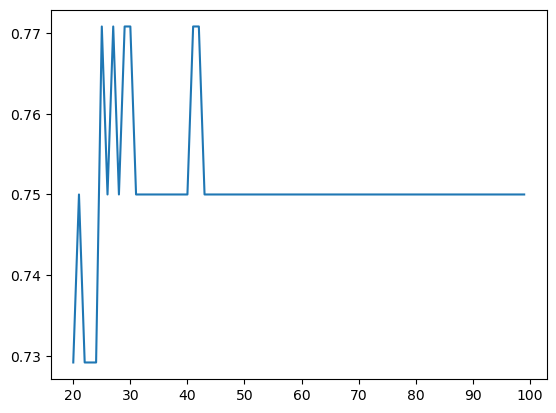

In [66]:
lbfgs = pd.DataFrame(performance['lbfgs'])
lbfgs['Iterations'] = max_iter

from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(lbfgs['Iterations'], lbfgs['recall_1'])



## Model 2: Decision Tree

In [72]:
def decision_tree(depth):
    model_4 = DecisionTreeClassifier(max_depth=depth)

    # Fitting the model
    model_4 = model_4.fit(X_train_scaled, y_train)

    # Making predictions using the testing data
    predictions_4 = model_4.predict(X_test_scaled)

    # Model performance
    model_4_metrics = model_performance(y_test, predictions_4, VERBOSE)

    return model_4_metrics


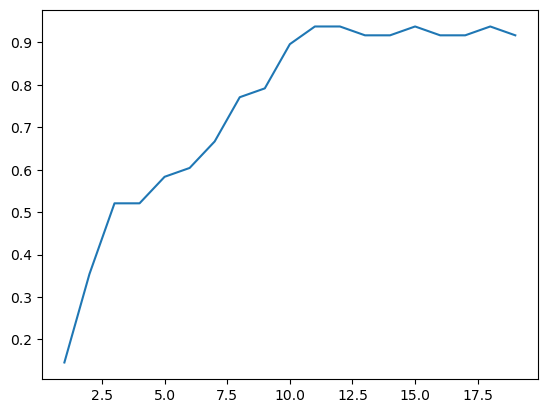

In [82]:
# Creating the decision tree classifier instance
depth = list(range(1,20))

perfs_4 = []

for d in depth:
    model_4_metrics = decision_tree(d)
    perfs_4.append(model_4_metrics['recall_1'])

# Plot
fig, ax = plt.subplots()
ax.plot(depth, perfs_4)

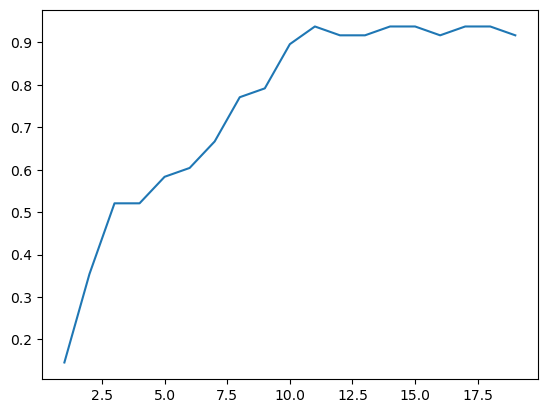